<a href="https://colab.research.google.com/github/arkalim/Tensorflow/blob/master/UNET_Kitti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Road Segmentation using UNET
In this notebook, we perform road segmentation on Kitti Road Dataset

In [0]:
import tensorflow as tf

img_shape = (160, 576,3)
batch_size = 16

In [0]:
# Import necessary libraries
import cv2
import os
import glob
import zipfile
import functools

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image

import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K  

# Download Kitti Road Dataset

In [0]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_road.zip
!unzip data_road.zip    

--2019-06-19 05:37:39--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_road.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.72.123
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.72.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 470992343 (449M) [application/zip]
Saving to: ‘data_road.zip’

data_road.zip       100%[===================>] 449.17M  30.3MB/s    in 16s     

2019-06-19 05:37:55 (28.2 MB/s) - ‘data_road.zip’ saved [470992343/470992343]

Archive:  data_road.zip
   creating: data_road/
   creating: data_road/training/
   creating: data_road/testing/
   creating: data_road/training/image_2/
  inflating: data_road/training/image_2/umm_000032.png  
  inflating: data_road/training/image_2/umm_000031.png  
  inflating: data_road/training/image_2/umm_000030.png  
  inflating: data_road/training/image_2/umm_000029.png  
  inflating: data_road/training/image_2/umm_000028.png 

In [0]:
import os
os.listdir('data_road/training/gt_image_2')

['umm_road_000013.png',
 'umm_road_000058.png',
 'um_road_000013.png',
 'uu_road_000054.png',
 'umm_road_000000.png',
 'um_road_000023.png',
 'um_road_000067.png',
 'umm_road_000074.png',
 'um_lane_000069.png',
 'umm_road_000053.png',
 'um_lane_000094.png',
 'um_road_000064.png',
 'um_lane_000062.png',
 'umm_road_000043.png',
 'umm_road_000012.png',
 'um_lane_000028.png',
 'um_road_000070.png',
 'um_road_000046.png',
 'um_road_000060.png',
 'uu_road_000086.png',
 'um_lane_000005.png',
 'um_road_000094.png',
 'um_road_000055.png',
 'um_road_000028.png',
 'uu_road_000007.png',
 'um_road_000042.png',
 'umm_road_000055.png',
 'um_lane_000012.png',
 'um_lane_000057.png',
 'umm_road_000054.png',
 'uu_road_000040.png',
 'um_road_000062.png',
 'um_lane_000078.png',
 'umm_road_000077.png',
 'um_lane_000050.png',
 'um_road_000009.png',
 'uu_road_000046.png',
 'um_road_000076.png',
 'umm_road_000086.png',
 'um_lane_000035.png',
 'uu_road_000072.png',
 'umm_road_000050.png',
 'um_lane_000031.png',

# Visualise the raw dataset

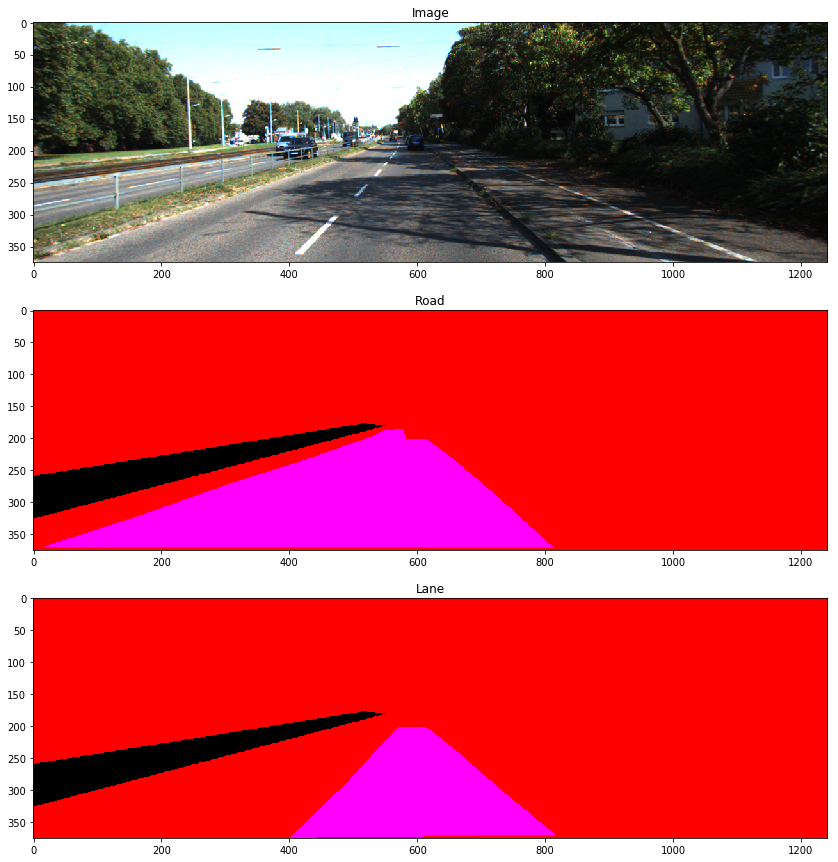

In [0]:
plt.figure(figsize=(45,15))

plt.subplot(3,1,1)
plt.imshow(mpimg.imread('data_road/training/image_2/um_000015.png'))
plt.title("Image")

plt.subplot(3,1,2)
plt.imshow(mpimg.imread('data_road/training/gt_image_2/um_road_000015.png'))
plt.title("Road")

plt.subplot(3,1,3)
plt.imshow(mpimg.imread('data_road/training/gt_image_2/um_lane_000015.png'))
plt.title("Lane")

plt.show()

# Process the filenames (paths)

In [0]:
train_path = 'data_road/training/'

train_filenames = []
train_labels_filenames = []

for filename in os.listdir(os.path.join(train_path , 'image_2')):
    train_filenames.append(os.path.join(os.path.join(train_path , 'image_2'), filename))
        
for filename in os.listdir(os.path.join(train_path , 'gt_image_2')):
    if filename.startswith('um_road') or filename.startswith('uu_road') or filename.startswith('umm_road'):
        train_labels_filenames.append(os.path.join(os.path.join(train_path , 'gt_image_2'), filename)) 
        
train_filenames.sort()
train_labels_filenames.sort()        
        
train_filenames, valid_filenames, train_labels_filenames, valid_labels_filenames = train_test_split(train_filenames, train_labels_filenames, test_size=0.1, random_state=42)            
                
num_train_examples = len(train_filenames)
num_val_examples = len(valid_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))   

Number of training examples: 260
Number of validation examples: 29


In [0]:
train_filenames[:10]

['data_road/training/image_2/um_000060.png',
 'data_road/training/image_2/umm_000006.png',
 'data_road/training/image_2/umm_000090.png',
 'data_road/training/image_2/umm_000059.png',
 'data_road/training/image_2/uu_000046.png',
 'data_road/training/image_2/umm_000088.png',
 'data_road/training/image_2/umm_000073.png',
 'data_road/training/image_2/uu_000041.png',
 'data_road/training/image_2/umm_000048.png',
 'data_road/training/image_2/uu_000011.png']

In [0]:
train_labels_filenames[:10]

['data_road/training/gt_image_2/um_road_000060.png',
 'data_road/training/gt_image_2/umm_road_000006.png',
 'data_road/training/gt_image_2/umm_road_000090.png',
 'data_road/training/gt_image_2/umm_road_000059.png',
 'data_road/training/gt_image_2/uu_road_000046.png',
 'data_road/training/gt_image_2/umm_road_000088.png',
 'data_road/training/gt_image_2/umm_road_000073.png',
 'data_road/training/gt_image_2/uu_road_000041.png',
 'data_road/training/gt_image_2/umm_road_000048.png',
 'data_road/training/gt_image_2/uu_road_000011.png']

# Visualise the dataset
Here is how the images and masks in the dataset look like

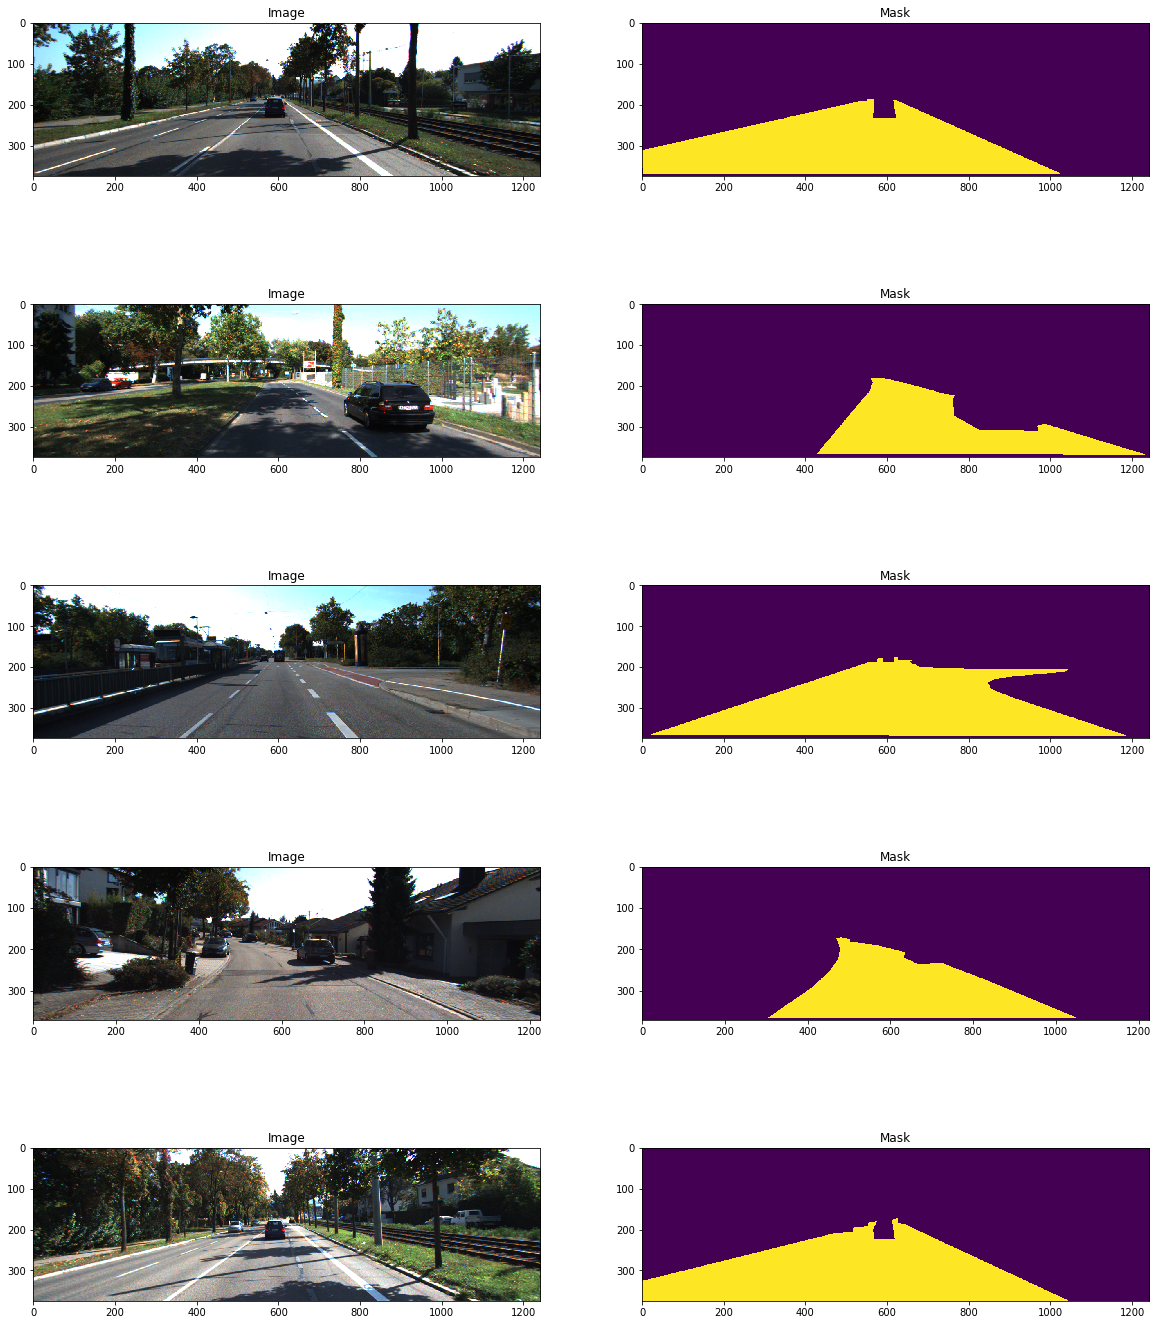

In [0]:
# Number of items to be displayed
display_num = 5

# Randomly selecting the examples from the dataset
random_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(20, display_num * 5))

for i in range(display_num):
    
    img_num = random_choices[i]

    image_pathname = train_filenames[img_num]
    mask_pathname = train_labels_filenames[img_num]

    plt.subplot(display_num, 2 , 2*i+1)
    plt.imshow(mpimg.imread(image_pathname))
    plt.title("Image")
    
    plt.subplot(display_num, 2 , 2*i+2)
    mask = cv2.imread(mask_pathname,0)
    _, mask = cv2.threshold(mask, 80, 255, cv2.THRESH_BINARY)
    plt.imshow(mask)
    plt.title("Mask")

plt.show()

In [0]:
# Function that performs all the required augmentations
class augment(object):
    
    def __init__(self, scale = 1, color_shift = False, resize = None, horizontal_flip = False, vertical_flip = False, width_shift_range = 0.0, height_shift_range = 0.0, 
                 hue_delta = 0.2, brightness_delta = 0.2, saturation_min = 0.8, saturation_max = 1.2, contrast_min = 0.8, contrast_max = 1.2):

        self.resize = resize
        self.scale = scale
        self.horizontal_flip = horizontal_flip
        self.vertical_flip = vertical_flip
        self.width_shift_range = width_shift_range
        self.height_shift_range = height_shift_range 
        self.color_shift = color_shift
        self.hue_delta = hue_delta
        self.brightness_delta = brightness_delta
        self.saturation_min = saturation_min
        self.saturation_max = saturation_max
        self.contrast_min = contrast_min
        self.contrast_max = contrast_max
        
    def flip(self, image, mask):
        
        if self.horizontal_flip:
            con = tf.image.random_flip_left_right(con)
        if self.vertical_flip:    
            con = tf.image.random_flip_up_down(con)
        
        return image, mask  
    
    
    def translate(self,image, mask):
        
        if self.width_shift_range or self.height_shift_range:

            if self.width_shift_range:
                width_shift = tf.random_uniform([], -self.width_shift_range * img_shape[1], self.width_shift_range * img_shape[1])

            if self.height_shift_range:
                height_shift = tf.random_uniform([], -self.height_shift_range * img_shape[0], self.height_shift_range * img_shape[0])

            # Translate the image
            image = tfcontrib.image.translate(image, [width_shift, height_shift])
            mask = tfcontrib.image.translate(mask, [width_shift, height_shift])
            
        
        return image, mask
    
    def color(self, image, mask):
        
        if self.color_shift:
            image = tf.image.random_hue(image, self.hue_delta)
            image = tf.image.random_saturation(image, self.saturation_min, self.saturation_max)
            image = tf.image.random_brightness(image, self.brightness_delta)
            image = tf.image.random_contrast(image, self.contrast_min, self.contrast_max)
            
        return image, mask    
    
       
    def __call__(self, image, mask):
        
        if self.resize is not None:
            # Resize the image
            image = tf.image.resize_images(image, self.resize)
            mask = tf.image.resize_images(mask, self.resize)
            
        image, mask = self.translate(image, mask)    

        image, mask = self.flip(image, mask)    

        image, mask = self.color(image, mask)           
       
        image = tf.to_float(image) * self.scale 

        return image, mask

In [0]:
train_augment = augment(scale = 1/255., color_shift = True, resize = [img_shape[0],img_shape[1]], width_shift_range = 0.2, height_shift_range = 0.2, 
                 hue_delta = 0.3, brightness_delta = 0.3, saturation_min = 0.7, saturation_max = 1.3, contrast_min = 0.7, contrast_max = 1.3)

valid_augment = augment(scale = 1/255., resize = [img_shape[0],img_shape[1]])

In [0]:
def process_filenames(filename, mask_filename):
   
  img_str = tf.read_file(filename)
  image = tf.image.decode_jpeg(img_str, channels=3)

  mask_str = tf.read_file(mask_filename)
  mask = tf.image.decode_jpeg(mask_str, channels=3)
  mask = tf.image.rgb_to_grayscale(mask)
  # Thresholding the image tensor  
  mask = tf.cast((mask > 80),tf.float32)    

  return image, mask

In [0]:
# Function to create a dataset after data augmentation
def get_dataset(filenames, labels, shuffle, batch_size, preprocess_func, name = 'dataset'):
               
    with tf.name_scope(name):    
        
        num_x = len(filenames)

        # Create a dataset from the filenames and labels
        dataset = tf.data.Dataset.from_tensor_slices((filenames, labels)) 

        dataset = dataset.map(process_filenames, num_parallel_calls = 5)

        dataset = dataset.map(preprocess_func, num_parallel_calls = 5)
        
        if shuffle:
            dataset = dataset.shuffle(num_x)

        # It's necessary to repeat our data for all epochs 
        dataset = dataset.repeat().batch(batch_size)

        return dataset

# Prepare training dataset
train_ds = get_dataset(train_filenames, train_labels_filenames, shuffle = True, batch_size = batch_size, preprocess_func = train_augment, name = 'train_dataset')

# Prepare training dataset
valid_ds = get_dataset(valid_filenames, valid_labels_filenames, shuffle = True, batch_size = batch_size, preprocess_func = valid_augment, name = 'valid_dataset')

W0619 05:43:29.855026 140571271612288 deprecation.py:323] From <ipython-input-14-4645d0d6d72d>:71: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


In [0]:
temp_ds = get_dataset(train_filenames, train_labels_filenames, shuffle = True, batch_size = batch_size, preprocess_func = train_augment, name = 'temp_dataset')

display_num = 5

# Randomly selecting the examples from the dataset
random_choices = np.random.choice(batch_size, display_num)

# Let's examine some of these augmented images
data_aug_iter = temp_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()

# Running next element in our graph will produce an image since batch size = 1
with tf.Session() as sess: 
    img, mask = sess.run(next_element)

    plt.figure(figsize=(20, 5 * display_num))

    for i in range(display_num):

        img_num = random_choices[i]

        plt.subplot(display_num,2,2*i+1)  
        plt.imshow(img[img_num,:,:,:])
        plt.title("Augmented Image")

        plt.subplot(display_num,2,2*i+2)
        plt.imshow(mask[img_num,:,:,0])
        plt.title("Augmented Mask")
        


# Load the model

In [0]:
# Defing the convolutional block
def conv_block(input_tensor, num_filters):
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  return encoder

# Defining encoder block
def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  return encoder_pool, encoder

# Defining decoder block
def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  return decoder

inputs = layers.Input(shape=img_shape)

encoder0_pool, encoder0 = encoder_block(inputs, 32)

encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)

encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)

encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)

encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)

center = conv_block(encoder4_pool, 1024)

decoder4 = decoder_block(center, encoder4, 512)

decoder3 = decoder_block(decoder4, encoder3, 256)

decoder2 = decoder_block(decoder3, encoder2, 128)

decoder1 = decoder_block(decoder2, encoder1, 64)

decoder0 = decoder_block(decoder1, encoder0, 32)

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

# using keras functional API for defining model
model = models.Model(inputs=[inputs], outputs=[outputs])

W0619 05:43:36.064376 140571271612288 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

# loss function that combines binary cross entropy and dice loss
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

# Function to define the optimizers and loss

In [0]:
def optimize(predicted_masks, corrected_masks):
    
    loss = bce_dice_loss(corrected_masks, predicted_masks)
    
    variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

    # The model implements this operation to find the weights/parameters that would yield correct pixel labels
    optimizer_1 = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss, var_list = variables)
    optimizer_2 = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss, var_list = variables)
    optimizer_3 = tf.train.AdamOptimizer(learning_rate=0.00001).minimize(loss, var_list = variables)

    optimizers = [optimizer_1, optimizer_2, optimizer_3]
    epochs = [20,10,10]
    
    return loss, optimizers, epochs

# Function to train the model

In [0]:
def train(sess):
    
    print("################# Training #################")
    
    train_steps = int(np.ceil(num_train_examples / float(batch_size)))
    valid_steps = int(np.ceil(num_val_examples / float(batch_size)))

    for i, optimizer in enumerate(optimizers):

        print('############### Optimization: {} #################'.format(i+1))

        for epoch in range(epochs[i]):

            loss_train = 0
            loss_valid = 0

            for step in range(train_steps):
                    
                loss_train_step , _ = sess.run([loss, optimizer], feed_dict = {handle: train_handle})
                loss_train += loss_train_step

            for step in range(valid_steps):

                loss_valid_step = sess.run(loss, feed_dict = {handle: valid_handle})
                loss_valid += loss_valid_step

            loss_train /= train_steps    
            loss_valid /= valid_steps

            loss_train = np.mean(loss_train)
            loss_valid = np.mean(loss_valid)

            print ("Epoch " + str(epoch+1) + ", Train Loss= " + "{:.2f}".format(loss_train) + ", Valid Loss= " + "{:.2f}".format(loss_valid))   

# Function to predict

In [0]:
def predict(sess):
                    
    frames, prediction, loss_predict = sess.run([images,predicted_masks,loss], feed_dict = {handle: valid_handle})
    
    loss_predict = np.mean(loss_predict)
    print ("Prediction Loss= " + "{:.2f}".format(loss_predict))
    
    plt.figure(figsize=(10, 5 * batch_size))

    for img_num in range(batch_size):

        plt.subplot(batch_size,1,img_num+1)
        plt.imshow(frames[img_num,:,:,:])
        plt.imshow(prediction[img_num,:,:,0], alpha = 0.5)
        plt.title("Segmentation")

################# Training #################
############### Optimization: 1 #################
Epoch 1, Train Loss= 2.72, Valid Loss= 1.36
Epoch 2, Train Loss= 1.31, Valid Loss= 1.26
Epoch 3, Train Loss= 1.13, Valid Loss= 1.07
Epoch 4, Train Loss= 0.93, Valid Loss= 0.96
Epoch 5, Train Loss= 0.76, Valid Loss= 0.71
Epoch 6, Train Loss= 0.57, Valid Loss= 0.55
Epoch 7, Train Loss= 0.48, Valid Loss= 0.84
Epoch 8, Train Loss= 0.47, Valid Loss= 0.48
Epoch 9, Train Loss= 0.42, Valid Loss= 0.43
Epoch 10, Train Loss= 0.41, Valid Loss= 0.43
Epoch 11, Train Loss= 0.38, Valid Loss= 0.39
Epoch 12, Train Loss= 0.35, Valid Loss= 0.46
Epoch 13, Train Loss= 0.36, Valid Loss= 0.43
Epoch 14, Train Loss= 0.34, Valid Loss= 0.40
Epoch 15, Train Loss= 0.35, Valid Loss= 0.35
Epoch 16, Train Loss= 0.31, Valid Loss= 0.39
Epoch 17, Train Loss= 0.34, Valid Loss= 0.38
Epoch 18, Train Loss= 0.31, Valid Loss= 0.33
Epoch 19, Train Loss= 0.35, Valid Loss= 0.38
Epoch 20, Train Loss= 0.32, Valid Loss= 0.37
##############

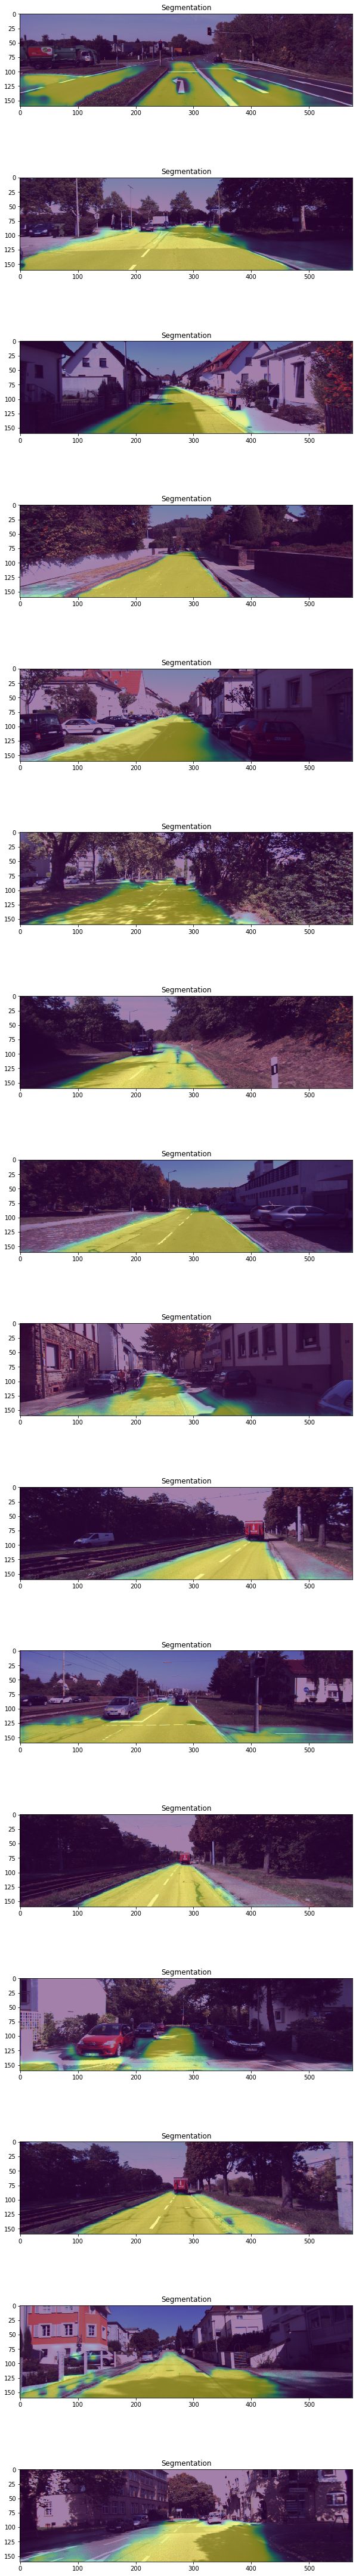

In [31]:
with tf.name_scope("Placeholders"):    
    handle = tf.placeholder(tf.string, shape=[])
    
with tf.name_scope("Initializer"):    
    # Defining the variable initialisation function
    init = tf.global_variables_initializer()    
    
# create initializable iterators from the dataset
train_iterator = train_ds.make_initializable_iterator()
valid_iterator = valid_ds.make_initializable_iterator() 
    
iterator = tf.data.Iterator.from_string_handle(handle, train_ds.output_types, train_ds.output_shapes)
next_element = iterator.get_next()
images, correct_masks = next_element

with tf.Session() as sess:
    
    # define the train and test handles (before training)
    train_handle = sess.run(train_iterator.string_handle())
    valid_handle = sess.run(valid_iterator.string_handle())
    
    # initialise both the iterators (before training)
    sess.run(train_iterator.initializer)
    sess.run(valid_iterator.initializer)

    predicted_masks = model(images)
    
    loss, optimizers, epochs = optimize(predicted_masks, correct_masks)    
    
    # Initialise the variables
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())

    # Train the neural network
    train(sess)
    
    # Predict the model on a batch of images
    predict(sess)